In [1]:
import pandas as pd 
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
scenario_1, scenario_2 = {}, {}
sce_paths= "../data/raw/scenario01/csv/*.csv"

def read_files_to_dataframe(path):
    df = {}
    for file in glob.glob(path):
        tmp_df = pd.read_csv(file)
        file_sep = file.split(os.sep)
        df_name = file_sep[len(file_sep) - 1].split('.')[0]
        df[df_name] = tmp_df
    return df

scenario_1 = read_files_to_dataframe(sce_paths.format("scenario01"))
scenario_2 = read_files_to_dataframe(sce_paths.format("scenario02"))

# Scenarios

In [3]:
scenario_1.keys()

dict_keys(['allergies', 'careplans', 'claims', 'conditions', 'devices', 'encounters', 'imaging_studies', 'immunizations', 'medications', 'observations', 'organizations', 'patients', 'payers', 'payer_transitions', 'procedures', 'providers', 'supplies'])

In [4]:
scenario_2.keys()

dict_keys(['allergies', 'careplans', 'claims', 'conditions', 'devices', 'encounters', 'imaging_studies', 'immunizations', 'medications', 'observations', 'organizations', 'patients', 'payers', 'payer_transitions', 'procedures', 'providers', 'supplies'])

In [5]:
print('column - scenario_1 - scenario_2')
for i in scenario_1.keys():
    print(i, '-', scenario_1[i].shape,'-', scenario_2[i].shape)

column - scenario_1 - scenario_2
allergies - (885, 15) - (885, 15)
careplans - (3745, 9) - (3745, 9)
claims - (113255, 31) - (113255, 31)
conditions - (36396, 6) - (36396, 6)
devices - (855, 7) - (855, 7)
encounters - (59481, 15) - (59481, 15)
imaging_studies - (164919, 13) - (164919, 13)
immunizations - (17124, 6) - (17124, 6)
medications - (53774, 13) - (53774, 13)
observations - (515299, 9) - (515299, 9)
organizations - (1406, 11) - (1406, 11)
patients - (1174, 25) - (1174, 25)
payers - (10, 21) - (10, 21)
payer_transitions - (51053, 8) - (51053, 8)
procedures - (108206, 9) - (108206, 9)
providers - (7087, 12) - (7087, 12)
supplies - (7813, 6) - (7813, 6)


# Análise exploratória 

#### Quantidade de pacientes

In [6]:
'scenario_1: {}, scenario_2: {}'.format(scenario_1['patients'].drop_duplicates(subset=['Id']).shape[0],\
                                        scenario_2['patients'].drop_duplicates(subset=['Id']).shape[0])

'scenario_1: 1174, scenario_2: 1174'

#### Quantidade de mortos

In [7]:
'scenario_1: {}, scenario_2: {}'.format(scenario_1['patients'].dropna(subset=['DEATHDATE']).shape[0],\
                                        scenario_2['patients'].dropna(subset=['DEATHDATE']).shape[0])

'scenario_1: 174, scenario_2: 174'

#### Idade de falecimento

In [8]:
scenario_1['patients']['BIRTHDATE'] = pd.to_datetime(scenario_1['patients']['BIRTHDATE'])
scenario_1['patients']['DEATHDATE'] = pd.to_datetime(scenario_1['patients']['DEATHDATE'])

scenario_2['patients']['BIRTHDATE'] = pd.to_datetime(scenario_1['patients']['BIRTHDATE'])
scenario_2['patients']['DEATHDATE'] = pd.to_datetime(scenario_1['patients']['DEATHDATE'])

In [9]:
scenario_1['patients']['AGE_DEATH'] = [scenario_1['patients'].iloc[i]['DEATHDATE'].year - \
                                       scenario_1['patients'].iloc[i]['BIRTHDATE'].year\
                                       for i in range(len(scenario_1['patients']))]

scenario_2['patients']['AGE_DEATH'] = [scenario_2['patients'].iloc[i]['DEATHDATE'].year - \
                                       scenario_2['patients'].iloc[i]['BIRTHDATE'].year\
                                       for i in range(len(scenario_2['patients']))]

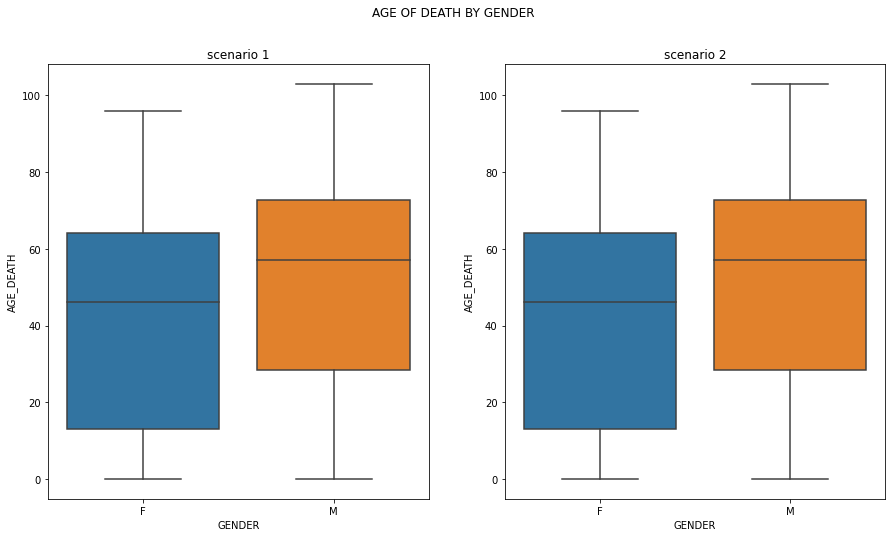

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))

sns.boxplot(x="GENDER", y="AGE_DEATH", data=scenario_1['patients'], ax=axs[0])
sns.boxplot(x="GENDER", y="AGE_DEATH", data=scenario_2['patients'], ax=axs[1])
axs[0].set_title('scenario 1')
axs[1].set_title('scenario 2')
fig.suptitle('AGE OF DEATH BY GENDER')
plt.show()

#### Causas mais comuns das mortes 

In [11]:
def patient_last_encounter(data):
    encounters = data['encounters']
    encounters['row_number'] = encounters.sort_values(['START'], ascending=[False]) \
             .groupby(['PATIENT']) \
             .cumcount() + 1
    last_encounters =  encounters[encounters['row_number'] == 1]
    patients_last_encounter = data['patients'].merge(last_encounters, left_on='Id', \
                                         right_on='PATIENT', suffixes=('_patient', '_encounter'))
    patients_last_encounter['death_threshold'] = pd.to_datetime(patients_last_encounter['DEATHDATE']).dt.tz_localize(None) - \
    pd.to_datetime(patients_last_encounter['START']).dt.tz_localize(None) <= datetime.timedelta(days=7)
    
    return patients_last_encounter

In [12]:
patients_last_encounter_1 = patient_last_encounter(scenario_1)
patients_last_encounter_2 = patient_last_encounter(scenario_2)


In [13]:
death_patients_1 = patients_last_encounter_1.dropna(subset=['DEATHDATE'])
death_patients_2 = patients_last_encounter_2.dropna(subset=['DEATHDATE'])


In [14]:
reason_death_1 = death_patients_1['REASONCODE'].value_counts()
reason_death_1 = pd.DataFrame({'id': reason_death_1.index.tolist(), 'count': reason_death_1.tolist()})

reason_death_2 = death_patients_2['REASONCODE'].value_counts()
reason_death_2 = pd.DataFrame({'id': reason_death_2.index.tolist(), 'count': reason_death_2.tolist()})

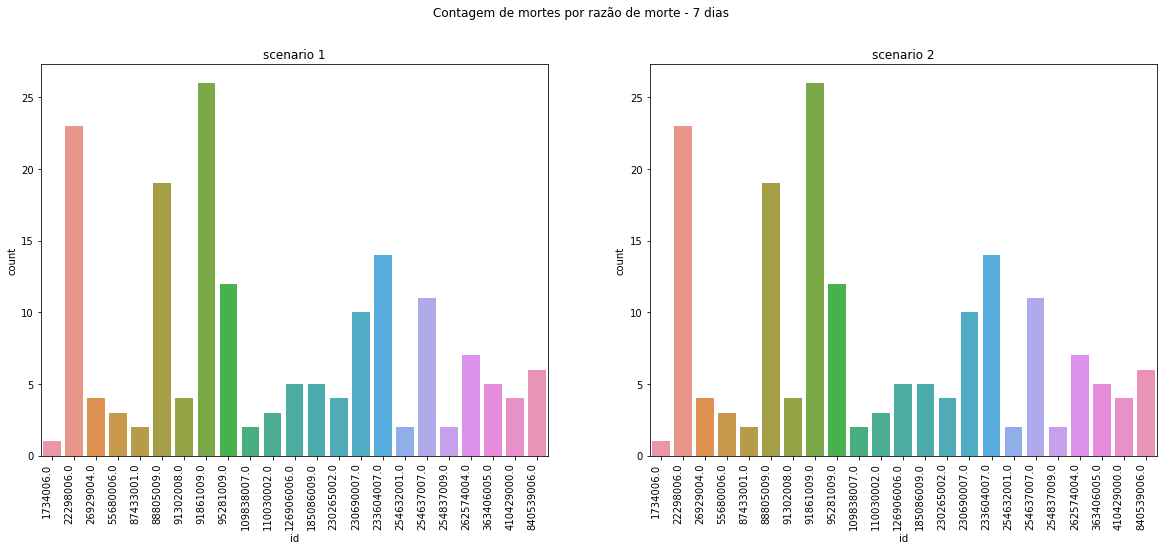

In [15]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
sns.barplot(x="id", y="count", data=reason_death_1, ax = axs[0])
sns.barplot(x="id", y="count", data=reason_death_2, ax = axs[1])
fig.autofmt_xdate(rotation=90)
axs[0].set_title('scenario 1')
axs[1].set_title('scenario 2')
plt.suptitle('Contagem de mortes por razão de morte - 7 dias')
plt.show()

In [16]:
'Maior causa de morte nos cenarios, 1: {}, 2: {}'.format(reason_death_1[reason_death_1['count'] == reason_death_1['count'].max()]['id'][0],\
                                                         reason_death_2[reason_death_2['count'] == reason_death_2['count'].max()]['id'][0])

'Maior causa de morte nos cenarios, 1: 91861009.0, 2: 91861009.0'

In [17]:
reason_death_1.shape, reason_death_2.shape

((23, 2), (23, 2))

In [18]:
in_both_scenarios = reason_death_1[reason_death_1['id'].isin(reason_death_2['id'])]['id']

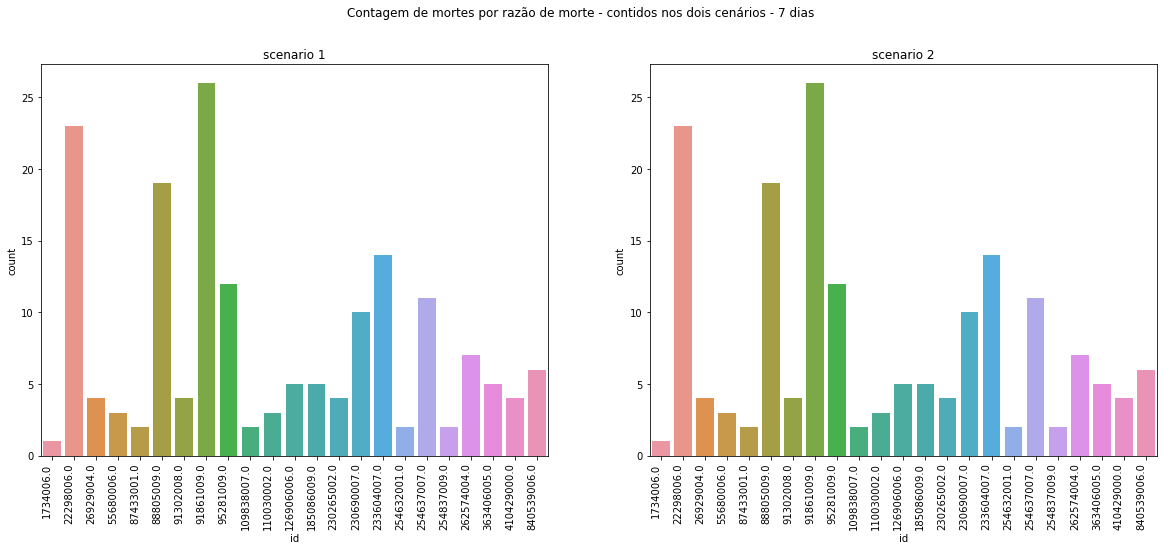

In [19]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
sns.barplot(x="id", y="count", data=reason_death_1[reason_death_1['id'].isin(in_both_scenarios)], ax = axs[0])
sns.barplot(x="id", y="count", data=reason_death_2[reason_death_2['id'].isin(in_both_scenarios)], ax = axs[1])
fig.autofmt_xdate(rotation=90)
axs[0].set_title('scenario 1')
axs[1].set_title('scenario 2')
plt.suptitle('Contagem de mortes por razão de morte - contidos nos dois cenários - 7 dias')
plt.show()

Observando-se os graficos nota-se que as causas da morte que mais contem dados sobre nos dois datasets é o id 88805009 - referente pelo snomed como 'Chronic congestive heart failure'

In [20]:
patients_last_encounter_1.shape

(1174, 43)

In [21]:
patients_last_encounter_1[patients_last_encounter_1['REASONCODE'] == 88805009]['death_threshold'].value_counts()

True     19
False     2
Name: death_threshold, dtype: int64

In [22]:
patients_last_encounter_1['death_threshold'].value_counts()

False    1001
True      173
Name: death_threshold, dtype: int64

## Features

careplans - Code (Code from SNOMED-CT) <
payer_transitions - X
observations - ?
organizations - X
supplies - ?
procedures - ?
providers - X
payers - X
patients - <
encounters - (59481, 15) - (55285, 15)
claims - the diagnoses 1, 2,3,4,5,6,7,8?
imaging_studies - X
devices - X
conditions - <
immunizations - code
medications - code
allergies - Type, severity?

In [23]:
scenario_1['allergies']

,START,STOP,PATIENT,ENCOUNTER,CODE,SYSTEM,DESCRIPTION,TYPE,CATEGORY,REACTION1,DESCRIPTION1,SEVERITY1,REACTION2,DESCRIPTION2,SEVERITY2
0,1976-12-20,NaN,0d679725-4ff2-9d28-e523-956496f182cb,62977e95-39f8-5a22-05ad-d8faa6ac7ff8,1191,Unknown,Aspirin,allergy,medication,21522001.0,Abdominal pain (finding),MODERATE,NaN,NaN,NaN
1,2003-10-23,NaN,f03f50be-20b1-3eae-2ed1-bb478bceb320,555181fd-9bb0-d8b8-e720-c1164a5449ce,84489001,Unknown,Mold (organism),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-10-23,NaN,f03f50be-20b1-3eae-2ed1-bb478bceb320,555181fd-9bb0-d8b8-e720-c1164a5449ce,5640,Unknown,Ibuprofen,allergy,medication,270474007.0,Flushes/goes red (finding),MODERATE,NaN,NaN,NaN
3,2003-10-23,NaN,f03f50be-20b1-3eae-2ed1-bb478bceb320,555181fd-9bb0-d8b8-e720-c1164a5449ce,7984,Unknown,Penicillin V,allergy,medication,271807003.0,Eruption of skin (disorder),MILD,247472004.0,Wheal (finding),MILD
4,2003-10-23,NaN,f03f50be-20b1-3eae-2ed1-bb478bceb320,555181fd-9bb0-d8b8-e720-c1164a5449ce,735029006,Unknown,Shellfish (substance),allergy,food,271807003.0,Eruption of skin (disorder),MODERATE,418290006.0,Itching (finding),MILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,1955-10-11,NaN,393030d3-4eb2-9ecd-a4c3-4770ea39da00,dde687f8-9882-0e1c-d9ed-cf2c5e41a672,762952008,Unknown,Peanut (substance),allergy,food,402387002.0,Allergic angioedema (disorder),MODERATE,247472004.0,Wheal (finding),MODERATE
881,1994-07-11,NaN,6f5224f5-8c33-5611-4a61-f792ee96cf3d,a9035e01-7f7f-4703-290f-15a6e7cecd58,111088007,Unknown,Latex (substance),allergy,environment,402387002.0,Allergic angioedema (disorder),MODERATE,247472004.0,Wheal (finding),MILD
882,1994-07-11,NaN,6f5224f5-8c33-5611-4a61-f792ee96cf3d,a9035e01-7f7f-4703-290f-15a6e7cecd58,29046,Unknown,Lisinopril,intolerance,medication,NaN,NaN,NaN,NaN,NaN,NaN
883,1985-06-30,NaN,05ae5966-cb9d-68e7-5fff-22b1115cde0c,8282c889-3c6f-cf28-9321-13db9fd5f69e,7984,Unknown,Penicillin V,allergy,medication,267036007.0,Dyspnea (finding),MILD,247472004.0,Wheal (finding),MILD


## Modelo 

In [24]:
patients_last_encounter_1.columns

Index(['Id_patient', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'AGE_DEATH', 'Id_encounter', 'START', 'STOP',
       'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS',
       'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST',
       'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION', 'row_number',
       'death_threshold'],
      dtype='object')

Fiquei com duvida sobre o CODE, bias?

In [25]:
patients_last_encounter_1.drop(columns=['Id_patient', 'DEATHDATE', 'AGE_DEATH', \
                                        'REASONDESCRIPTION', 'REASONCODE', 'PREFIX', \
                                        'FIRST', 'LAST', 'SUFFIX', 'DESCRIPTION', \
                                        'MAIDEN', 'SSN', 'CODE', 'ADDRESS', 'DRIVERS', 'PASSPORT',\
                                         'Id_encounter', 'row_number', 'LAT', 'LON'], inplace=True)
patients_last_encounter_1['BIRTHDATE'] = patients_last_encounter_1['BIRTHDATE'].dt.year


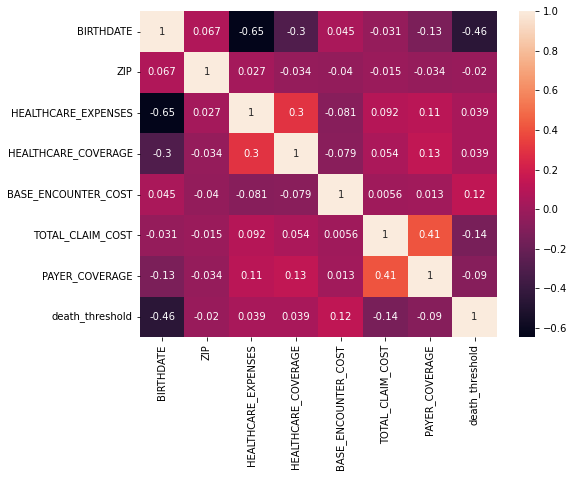

In [26]:
corr_df = patients_last_encounter_1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()